# Разработка A/B-тестирования и анализ результатов

Заказчик - компаниия, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Необходимо рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

**Что нужно сделать:**\
Рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

## Работа с историческими данными (EDA)

### Загрузка исторических данных
На первом этапе поработаем с историческими данными приложения:

- Импортируем необходимые библиотеки

- Прочитаем и сохраним в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей.

Выведем на экран первые пять строк полученного датафрейма.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from math import ceil
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest

session_history = pd.read_csv('https://code.s3.yandex.net/')
session_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


### Знакомство с данными

Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id` и выведем на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий.

In [2]:
# рассчитываем количество сессий для каждого пользователя и сортируем в порядке убывания
sessions_by_user = (session_history.groupby('user_id')
                    .agg({'session_id': 'nunique'})
                    .sort_values(ascending=False, by='session_id')
                    .reset_index()
                   )

# фильтруем исторические данные по пользователю с максимальным количеством сессий
display(session_history[session_history['user_id'] == sessions_by_user['user_id'][0]])

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


Первый и второй столбец представляют из себя списки уникальных значений - идентификатора пользователя и сессии. 3ий столбец вероятно формируется на базе столбца `session_start_ts` с помощью аксцессора `dt.date`. `install_date` формируется, видимо, на базе логов и далее дублируется для всех уникальных сессий пользователя. `session_number` также представляет собой уникальный идентификатор сессии, но уже в рамках окна - одного пользователя, скорее всего сформирован при выгрузке таблицы из базы данных и использовании оконных функций. `registration_flag` - просто бинарный признак регистрации пользователя. С остальными столбцами все более, чем понятно.

### Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования. Для визуализации используем линейный график

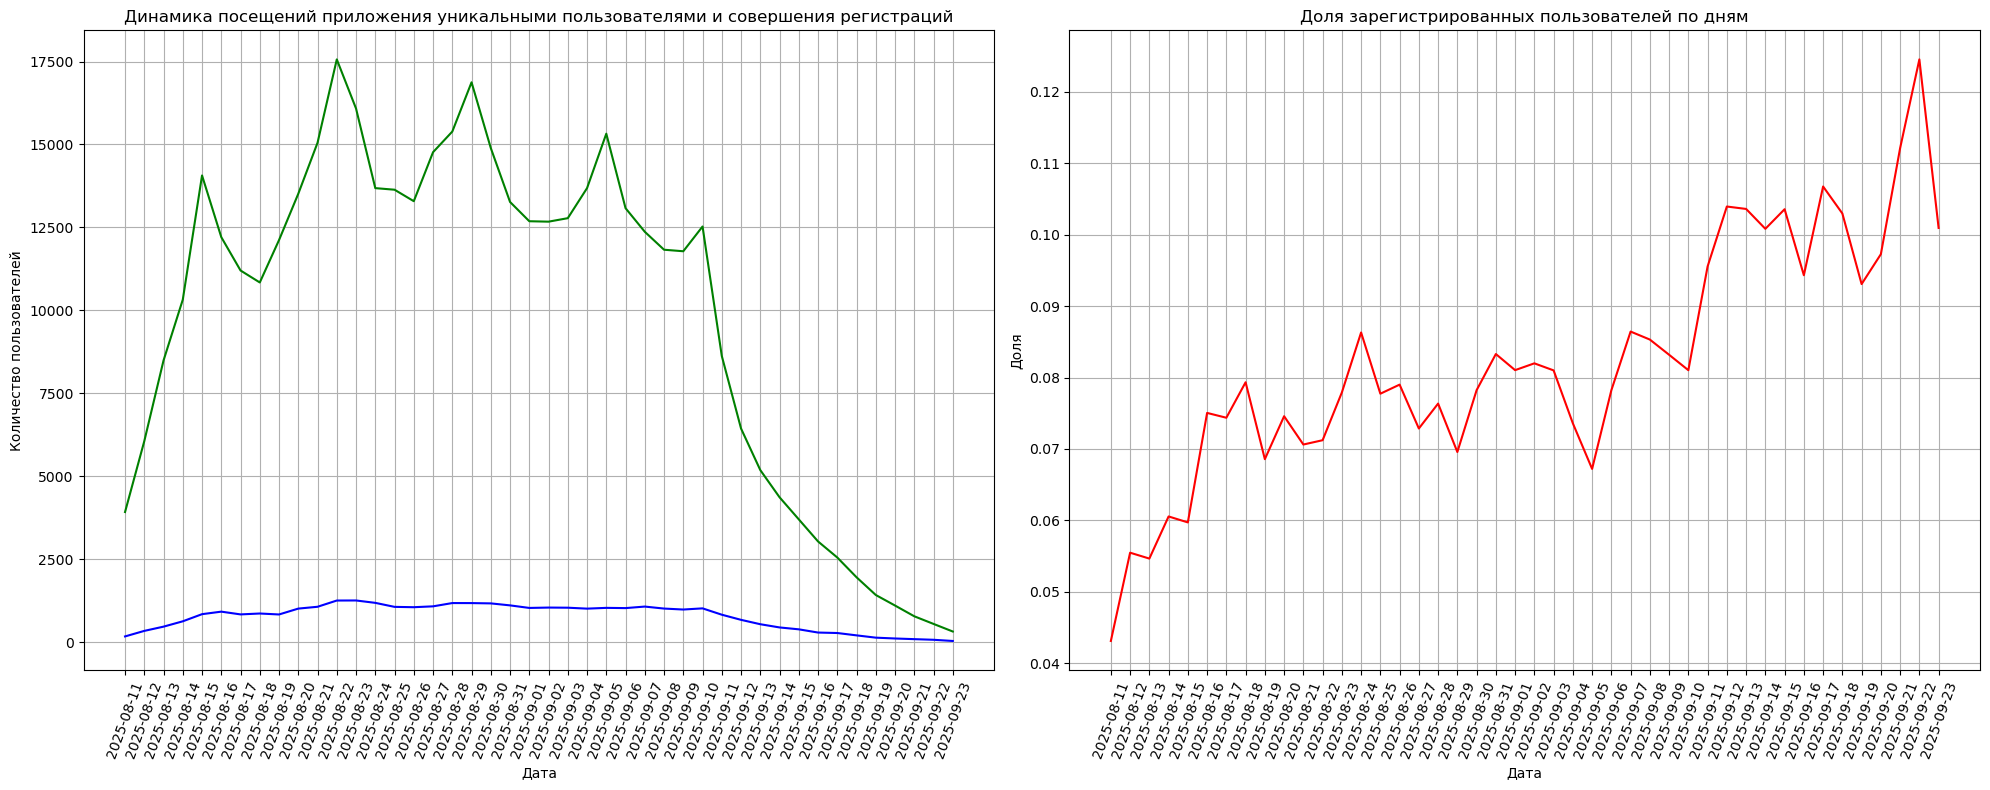

In [3]:
unique_users_registrations = (session_history.groupby('session_date')
                              .agg({'user_id': 'nunique', 'registration_flag': 'sum'})
                              .reset_index()
                             )
unique_users_registrations['share_of_registrations'] = unique_users_registrations['registration_flag']/unique_users_registrations['user_id']

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].plot(unique_users_registrations['session_date'], unique_users_registrations['user_id'], color='green')
axes[0].plot(unique_users_registrations['session_date'], unique_users_registrations['registration_flag'], color='blue')

axes[0].set_title('Динамика посещений приложения уникальными пользователями и совершения регистраций')
axes[0].set_ylabel('Количество пользователей')
axes[0].set_xlabel('Дата')
axes[0].tick_params(axis='x', labelrotation=70)

axes[0].grid(True)

axes[1].plot(unique_users_registrations['session_date'], unique_users_registrations['share_of_registrations'], color='red')
axes[1].set_title('Доля зарегистрированных пользователей по дням')
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Доля')
axes[1].tick_params(axis='x', labelrotation=70)
axes[1].grid(True)

plt.tight_layout()
plt.show()

По графикам видно, что количество уникальных пользователей начало резко сокращаться в десятых чисел сентября, при этом количество регистраций сократилось лишь незначительно.

Также благодаря второму графику видно, что доля регистраций наоборот начинает активно расти с десятых чисел сентября, при том, что общее количество уникальных пользователей падало, регистрации оставались на том же уровне. Как вариант, в приложение перестали привлекать нецелевой трафик, который не конвертировался в регистрации.

### Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку. Построим для этого столбчатую диаграмму:

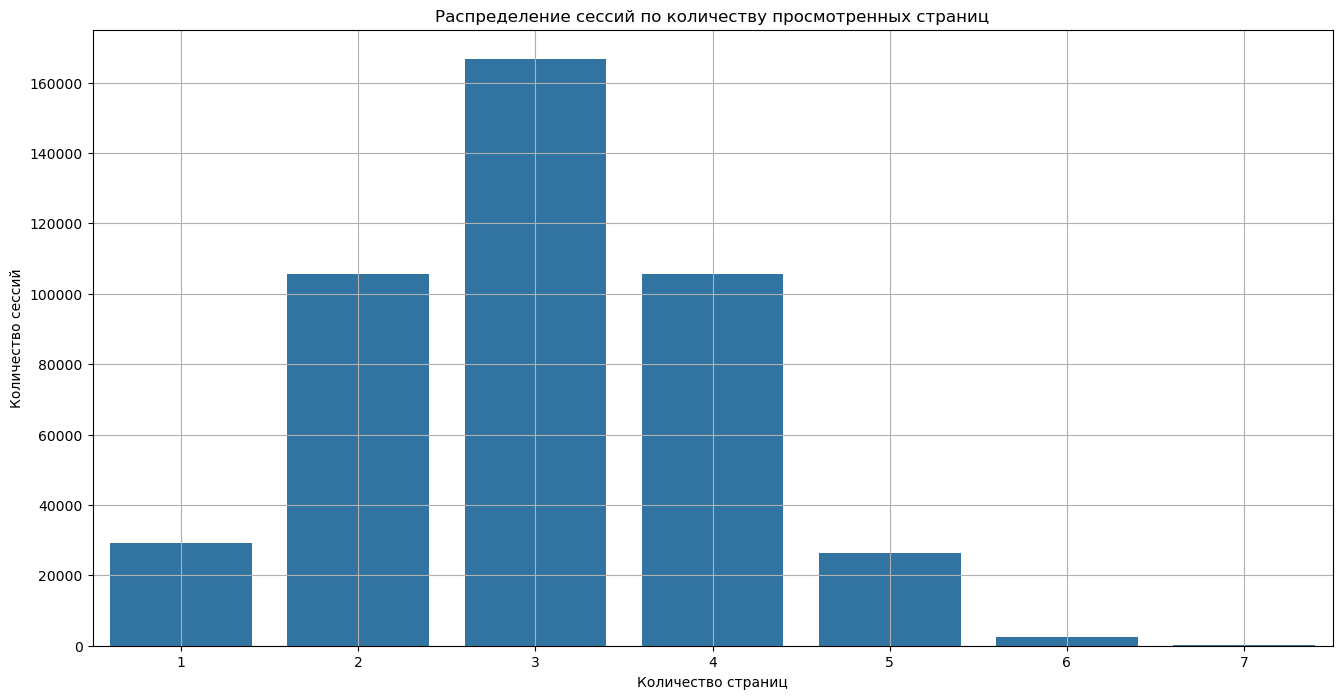

In [4]:
plt.figure(figsize=(16, 8))

sns.countplot(data=session_history, x='page_counter')

plt.title('Распределение сессий по количеству просмотренных страниц')
plt.xlabel('Количество страниц')
plt.ylabel('Количество сессий')
plt.grid(True)
plt.show()

Больше всего в рамках одной сессии пользователи просматривают 3 страницы. 6-7 страниц смотрят очень редко - менее 500 сессий имеют такое количество просмотренных страниц.

### Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше. 

Также построим график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

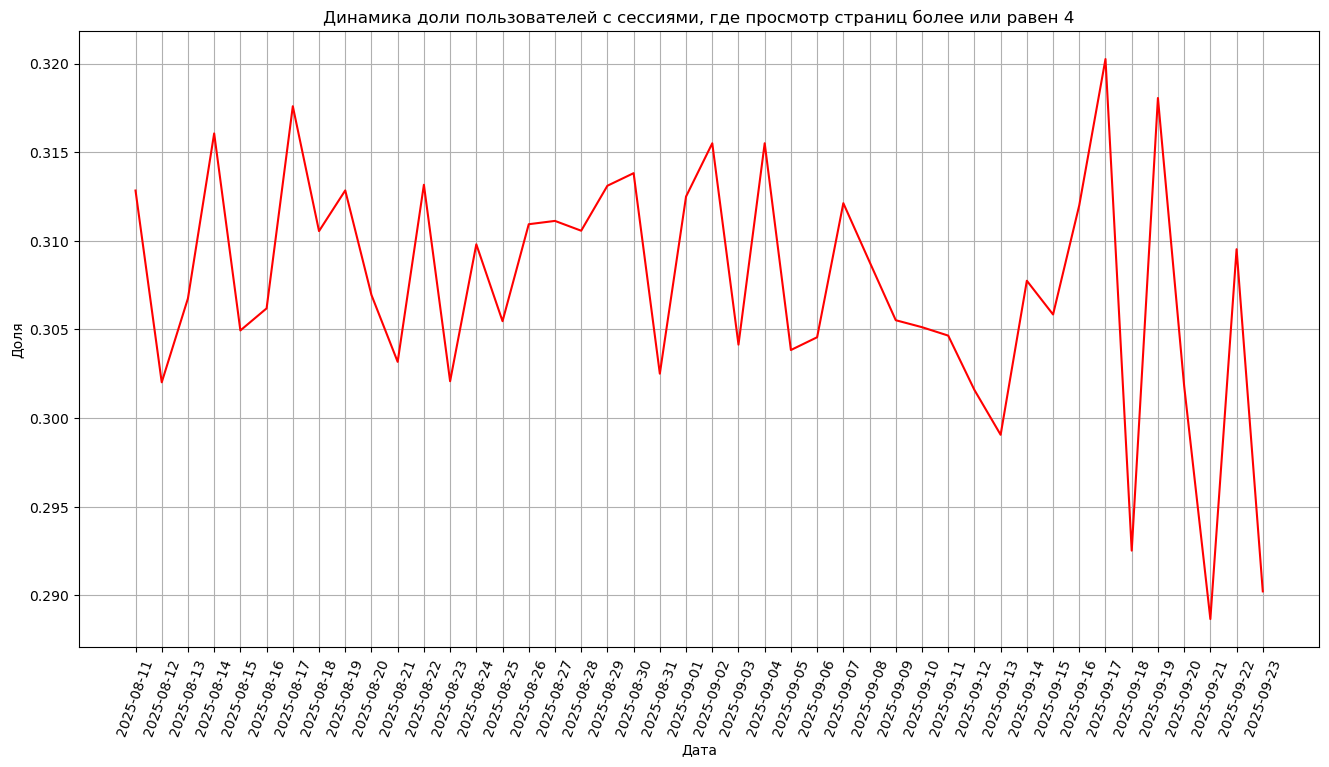

In [5]:
session_history['good_session'] = [1 if page >= 4 else 0 for page in session_history['page_counter']]
share_of_sessions = session_history.groupby('session_date', as_index=False).agg({'good_session': 'mean'})

plt.figure(figsize=(16, 8))

plt.plot(share_of_sessions['session_date'], share_of_sessions['good_session'], color='red')

plt.title('Динамика доли пользователей с сессиями, где просмотр страниц более или равен 4')
plt.xlabel('Дата')
plt.ylabel('Доля')
plt.xticks(rotation=70)
plt.grid(True)
plt.show()

По графику можно заметить, что также до 10 чисел сентября доля дердится в числовом коридоре от 0,3 до 0,31, более менее стабильно и без резких колебаний. А вот после 10 чисел сентября доля начинает скакать сильнее - от 0,28 до 0,32.

## Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

### Формулировка нулевой и альтернативной гипотез

В данном случае, если говорить о вовлеченности пользователей и проверки эффективности нового рекомендательного алгоритма, то за целевую метрику следует взять долю успешных сессий. Как прокси-метрику можно взять количество таких сессий с просмотром страниц 4 и более. Гипотезы тогда будут сформулированы следующим образом:

- H0: Доля успешных сессий в двух группах не отличается
- Н1: Доля успешных сессий меньше в контрольной группе (новый рекомендательный алгоритм показывает более интересный контент)

Так как мы будем сравнивать не средние выборок, статистический тест тоже выберем соответствующий - для работы с долевыми метриками.

### Расчёт размера выборки
При расчёте размера выборки используем метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Также установим следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

In [6]:
# задаём параметры
alpha = 0.05  # уровень значимости
beta = 0.2  # ошибка второго рода
power = 1 - beta  # мощность теста
p = 0.3 # базовый уровень доли
mde = 0.03 * p  # минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


### Расчёт длительности A/B-теста

Используем данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Определим длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения:

In [7]:
avg_daily_users = session_history['session_date'].value_counts().mean()

# рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size * 2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users:.0f} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 9 дней


## Мониторинг А/В-теста

### Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первый день. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие нас метрики корректно считаются.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B.

In [8]:
session_test_part = pd.read_csv('https://code.s3.yandex.net/')

a_group = session_test_part[session_test_part['test_group'] == 'A']
b_group = session_test_part[session_test_part['test_group'] == 'B']

n_a_first_day = a_group['user_id'].nunique()
n_b_first_day = b_group['user_id'].nunique()

print(f'Количество пользователей в группе А: {n_a_first_day}, а в группе В: {n_b_first_day}')

diff = round((n_a_first_day - n_b_first_day) / n_a_first_day, 6)
print(f'Разница между двумя группами: {diff:.6%}')

Количество пользователей в группе А: 1477, а в группе В: 1466
Разница между двумя группами: 0.744800%


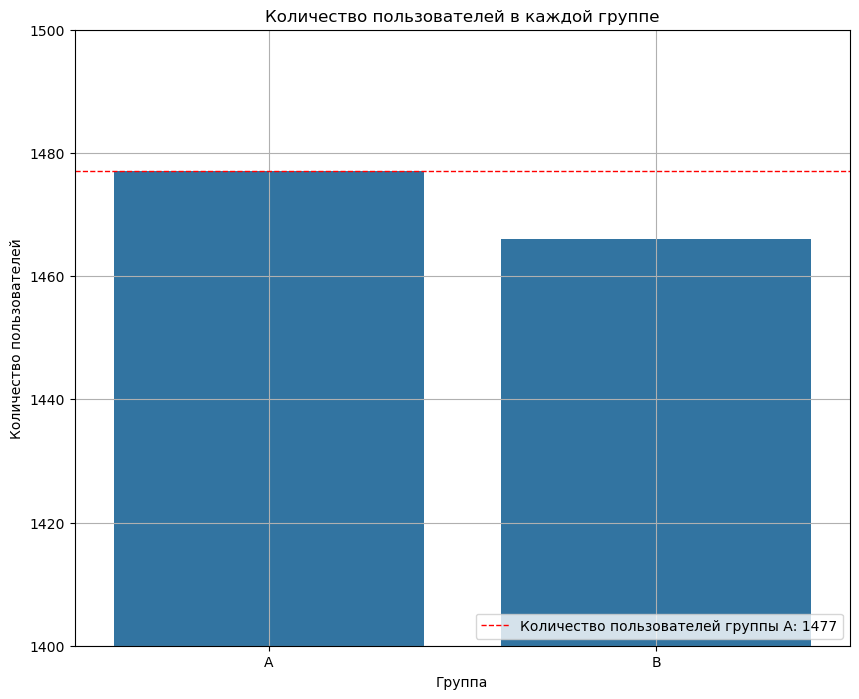

In [9]:
diff_users = session_test_part.groupby('test_group', as_index=False)['user_id'].nunique()

plt.figure(figsize=(10, 8))
sns.barplot(data=diff_users, x='test_group', y='user_id')
plt.axhline(n_a_first_day, color='red', linestyle='--', linewidth=1, label=f'Количество пользователей группы А: {n_a_first_day}')

plt.title('Количество пользователей в каждой группе')
plt.xlabel('Группа')
plt.ylabel('Количество пользователей')
plt.legend(loc='lower right')
plt.ylim(1400, 1500) # решила ограничить ось ординат, чтобы было лучше видно разницу
plt.grid(True)
plt.show()

Из визуализации и расчетов видно, что разница между группами незначительна - менее процента.

### Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, необходимо убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно. Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B, или убедимся, что таких нет:

In [10]:
a_first_day_user_id = a_group['user_id']
b_first_day_user_id = b_group['user_id']

inresection = list(set(a_first_day_user_id) & set(b_first_day_user_id))

print(len(inresection))

0


Пересечений нет - группы независимы и эксперимент проводится корректно с этой точки зрения.

### Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.


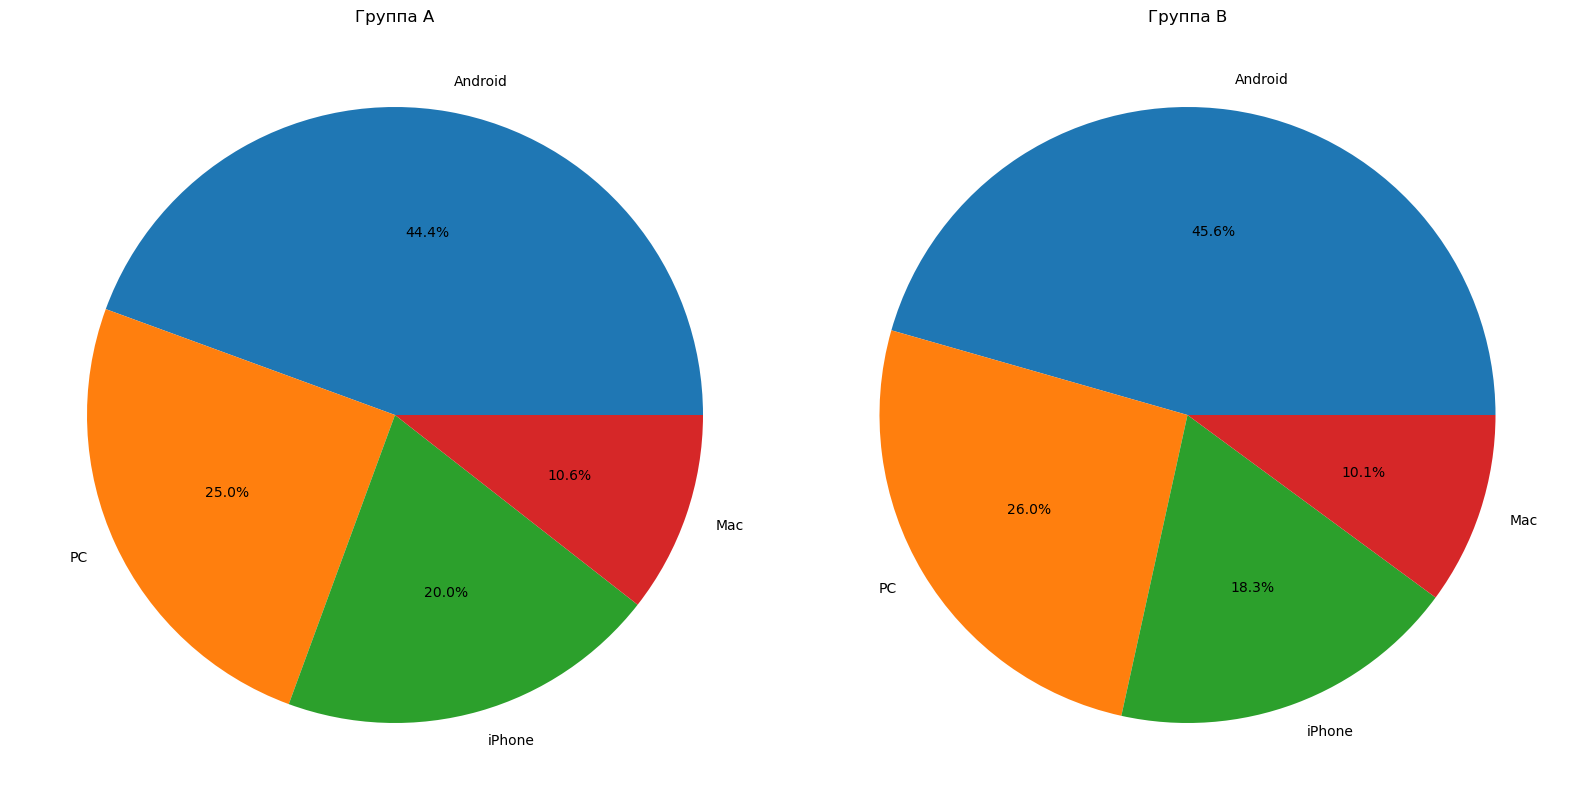

In [11]:
# так как у нас будут еще строится графики распределния долей, напишу функцию:
def pie_chart(group_1, group_2, category):
    """
    Функция принимает на вход:
    group_1 - датафрейм с данными контрольной группы
    group_2 - датафрейм с данными тестовой группы
    category - категория, по которой мы хотим посмотреть распределение
    
    На выходе у нас получается два пай-чарта с распределнием 
    нужной категории в двух группах с подписями процентов
    """
    unique_users_1 = group_1.drop_duplicates(subset=['user_id'])
    unique_users_2 = group_2.drop_duplicates(subset=['user_id'])
    grouped_data_1 = unique_users_1[category].value_counts()
    grouped_data_2 = unique_users_2[category].value_counts()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].pie(grouped_data_1, labels=grouped_data_1.index, autopct='%1.1f%%', normalize=True)
    axes[0].set_title('Группа A')
    
    axes[1].pie(grouped_data_2, labels=grouped_data_2.index, autopct='%1.1f%%', normalize=True)
    axes[1].set_title('Группа B')
    
    plt.tight_layout()
    plt.show()
    
pie_chart(a_group, b_group, 'device')

### Равномерность разделения пользователей по регионам
Теперь убедимся, что пользователи равномерно распределены по регионам.

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.


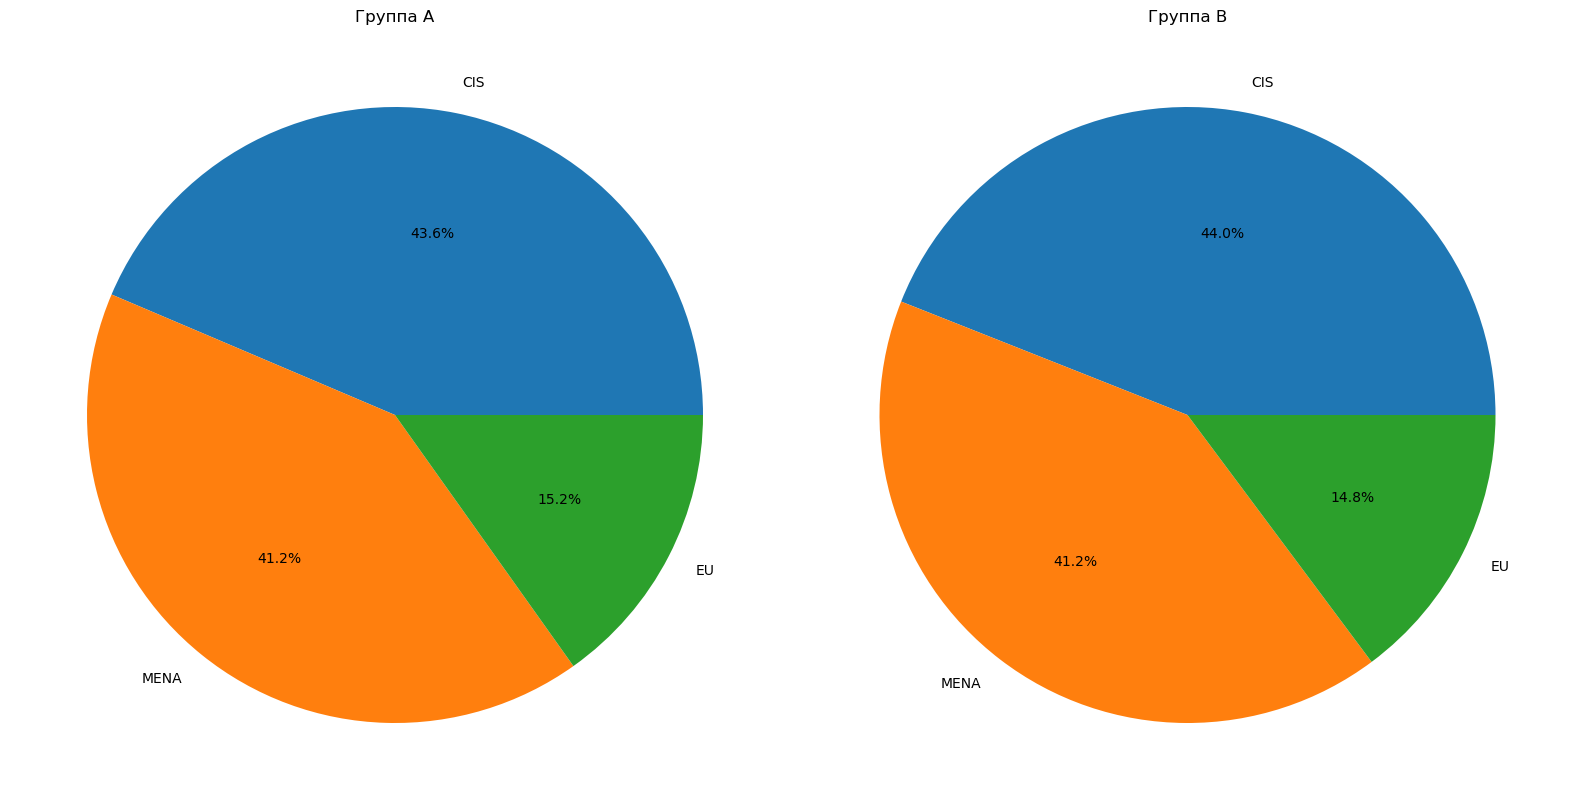

In [12]:
# использую функцию из предыдущей ячейки
pie_chart(a_group, b_group, 'region')

### Вывод после проверки A/B-теста

Подводя итог можно сказать, что количество пользователей отличается, но совершенно незначительно - всего лишь на 0,7%. Такое различие допустимо для дальнейшего проведения эксперимента

Также не было найдено пересчений идентификаторов групп пользователей - значит группы независимы и разделение на группы произошло корректно.

Что касается сопоставимости групп, их характеристик, то с этой точки зрения тоже все корректно - примерно одинаковое долевое распределение устройств. Регионы также не отличаются, самым многочисленным регионом является CIS, далее MENA, а потом EU.

## Проверка результатов A/B-теста

A/B-тест завершён, и у нас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

### Получение результатов теста и подсчёт основной метрики

Прочитаем и сохраним в датафрейм `sessions_test` CSV-файл с данными теста.

В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [13]:
session_test = pd.read_csv('https://code.s3.yandex.net/')
session_test['session_good'] = [1 if page >= 4 else 0 for page in session_test['page_counter']]

### Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и мы будем сравнивать две сопоставимые группы. Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку. 

Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используем статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

In [14]:
successful_sessions_a = session_test[session_test['test_group'] == 'A'].groupby(['session_date', 'test_group'])['session_id'].nunique()
successful_sessions_b = session_test[session_test['test_group'] == 'B'].groupby(['session_date', 'test_group'])['session_id'].nunique()

stat_test, p_value = st.ttest_ind(successful_sessions_a, successful_sessions_b, alternative='two-sided')

print(f'{p_value:.5f}')

0.93822


Значение p-value = 0,93822, что свидетельствует о том, что средние выборок очень схожи.

### Сравнение доли успешных сессий

Переходим к анализу ключевой метрики — доли успешных сессий.

Используем созданный на первом шаге задания столбец `good_session` и рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе:

In [15]:
share_successful_sessions_a = session_test[session_test['test_group'] == 'A']['session_good'].mean()
share_successful_sessions_b = session_test[session_test['test_group'] == 'B']['session_good'].mean()

print(f'Доля успешных сессий в группе А - {share_successful_sessions_a:.2f}, а в группе В - {share_successful_sessions_b:.2f}')
print(f'Разница в долях этих групп: {share_successful_sessions_b - share_successful_sessions_a:.2%}')

Доля успешных сессий в группе А - 0.31, а в группе В - 0.32
Разница в долях этих групп: 1.06%


### Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге мы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

Используем статистический тест (в данном случае Z-тест пропорций), рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым.

In [16]:
# используем Z-тест пропорций, так как у нас долевая метрика
# сначала рассчитаем условие достаточности данных

# расчет всех исходов
n_a = session_test[session_test['test_group'] == 'A'].shape[0]
n_b = session_test[session_test['test_group'] == 'B'].shape[0]

# расчет успешных исходов 
m_a = session_test[(session_test['test_group'] == 'A')&(session_test['session_good'] == 1)].shape[0]
m_b = session_test[(session_test['test_group'] == 'B')&(session_test['session_good'] == 1)].shape[0]

# расчет доли успехов с использованием буквенных варежений
# для удобства работы с этими переменными
p_a, p_b = m_a / n_a, m_b / n_b

# проверим условие достаточности данных
if (p_a * n_a > 10) and ((1 - p_a) * n_a > 10) and (p_b * n_b > 10) and ((1 - p_b) * n_b > 10):
    print('Данных для проведения статистического теста достаточно')
else:
    print('Данных для проведения статистического теста недостаточно')

Данных для проведения статистического теста достаточно


In [17]:
stat_ztest, z_pvalue = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)
print(f'p-value равен: {z_pvalue:.7f}')

if z_pvalue > alpha:
    print('Недостаточно оснований для отвержения нулевой гипотезы')
else:
    print('Отвергаем нулевую гипотезу, принимаем альтернативную гипотезу')

p-value равен: 0.0001575
Отвергаем нулевую гипотезу, принимаем альтернативную гипотезу


### Вывод по результатам A/B-эксперимента

Тест был проведен со следующими характеристиками:

- уровень значимости — 0.05.

- вероятность ошибки второго рода — 0.2.

- мощность теста - 0.8

- минимальный детектируемый эффект(MDE) — 3%.

В эксперименте было задействовано 30 579 уникальных пользователей, в группе А - 15 163, а в группе В - 15 416. Он длился 20 дней, с 14.10.2025 по 02.11.2025.

Ключевая метрика выросла - доля успешных сессий в тестовой группе увеличилась примерно на 1.1%. После расчета разницы была проведена проверка полученных результатов на статистическую значимость с помощью Z-теста пропорций, так как метрика была долевой.

P-value оказался равным примерно 0.0001575, при условии, что α = 0.05, нулевая гипотеза была отвергнута, альтернативная - принята.

Нововведение определенно нужно внедрять, так как получение такого p-value свидетельствует о том, что изменение явно не случайно и эффект изменения действительно присутствует.